# TORCHTEXT를 가지고 텍스트 분류하기
------------------------------
이 튜토리얼에서 아래 데이터를 가지고 `torchtext`에서 텍스트 분류 데이터셋을 어떻게 사용하는지 알아봅니다.
- AG_NEWS,
- SogouNews,
- DBpedia,
- YelpReviewPolarity,
- YelpReviewFull,
- YahooAnswers,
- AmazonReviewPolarity,
- AmazonReviewFull

아래 예제부터 위의 `TextClassification` 데이터셋들 중 하나를 사용하여 분류를 위하여 supervised learning 알고리즘을 어떻게 학습하는지 알아봅니다

## ngram으로 데이터 불러오기
ngram 피처(feature)는 단어 순서에 대한 일부 정보를 캡쳐하기 위해 사용됩니다. 실제로, bi-gram이나 tri-gram은 하나의 단어 보다 하나의 그룹된 단어로서 더 많은 이점을 제공하기 때문에 사용됩니다 예를들면 :

In [ ]:
"load data with ngrams"
Bi-grams results: "load data", "data with", "with ngrams"
Tri-grams results: "load data with", "data with ngrams"

`TextClassification` 데이터셋들은 이 ngram 메소드들을 제공합니다. ngram을 2로 세팅하면, 데이터셋의 예제 텍스트는 단일 단어와 bi-gram 문자열 리스트가 됩니다

In [1]:
import torch
import torchtext
from torchtext.datasets import text_classification
NGRAMS = 2
import os
if not os.path.isdir('./.data'):
    os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='./.data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ag_news_csv.tar.gz: 11.8MB [00:01, 7.83MB/s]
120000lines [00:09, 12814.33lines/s]
120000lines [00:16, 7105.15lines/s]
7600lines [00:01, 7266.74lines/s]


## 모델 정의

모델은 [EmbeddingBag](https://pytorch.org/docs/stable/nn.html?highlight=embeddingbag#torch.nn.EmbeddingBag) 레이어와 리니어 레이어(아래 사진을 참고하세요)로 이루어져 있습니다. `nn.EmbeddingBag`는 임베딩 "bag"의 평균 값을 계산합니다. 여기의 텍스트 항목들은 길이가 다릅니다. 텍스트 길이가 offsets으로 저장됐기 때문에 `nn.EmbeddingBag`는 여기서 채우는 것을 필요로하지 않습니다.

또한 `nn.EmbeddingBag`는 임베딩의 평균 값을 누적하므로 `nn.EmbeddingBag`는 텐서 시퀀스를 처리하는 성능과 메모리 효율성을 향상시킬 수 있습니다.

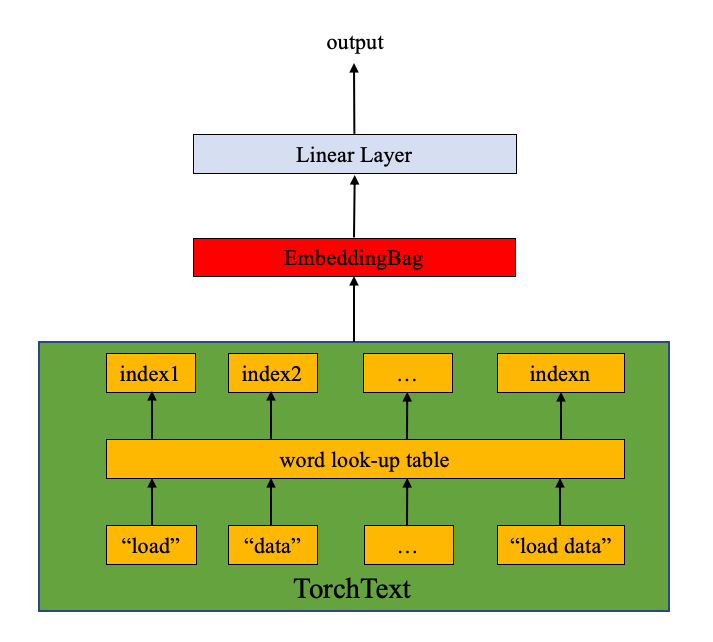

In [3]:
from IPython.display import Image
Image("images/text_sentiment_ngrams_model.png") 

In [2]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

## 인스턴스 초기화
AG_NEWS 데이터셋은 4개의 레이블들을 가지고 있기에 클래스의 개수는 4입니다

In [ ]:
1 : World
2 : Sports
3 : Business
4 : Sci/Tec

사전 크기(size)는 사전 길이(length)와 동일합니다(단일 단어와 ngram 포함). 클래스의 개수는 레이블의 개수와 동일하며 AG_NEW의 경우 4입니다

In [3]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

## 배치 생성에 사용되는 함수들
텍스트 항목들의 길이가 다르기 땜누에 사용자 정의 함수 generate_batch()를 사용하여 데이터 배치 및 오프셋을 생성합니다. 이 함수는 `torch.utils.data.DataLoader`의 `collate_fn`에 전달됩니다. `collate_fn`의 입력은 batch_size 크기의 텐서 리스트 이며 `collate_fn` 함수는 이들을 mini-batch로 패킹합니다(pack) 여기서 주의해야합니다. 꼭 collate_fn이 탑 레벨 함수로 선언되었는지 확인해야 합니다. 이를 통해 이 함수가 각각의 worker에서 사용할 수 있도록 보장해줍니다.

원래 데이터 배치 인풋의 텍스트 항목들은 리스트로 패킹되며 `nn.EmbeddingBag`의 인풋과 같이 concat된 단일 텐서입니다. 오프셋은 텍스트 텐서에서 개별 시퀀스의 시작을 나타내는 구분용 텐서입니다. 레이블은 개별 텍스트 항목의 레이블을 저장하는 텐서입니다

In [4]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

## 모델을 학습하고 평가하는 함수를 정의

`torch.utils.data.DataLoader`는 PyTorch 사용자에게 권장되며 데이터를 쉽게 병렬로 불러오도록 합니다.(tutorial [참고](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)) 여기서는 `DataLoader`를 사용하여 AG_NEWS 데이터셋을 로드하고 훈련/검증을 위하여 모델에 데이터셋을 전달합니다.

In [5]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

## 데이터셋을 나누고 모델을 실행

원래 AG_NEWS에는 검증용 데이터셋이 없기 때문에, 학습 셋을 학습이 0.95, 검증이 0.05가되게 학습/검증 셋으로 나눕니다. 여기서는 PyTorch 라이브러리인 [torch.utils.data.dataset.random_split](https://pytorch.org/docs/stable/data.html?highlight=random_split#torch.utils.data.random_split) 함수를 사용했습니다.

[CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)는 nn.LogSoftmax()와 nn.NLLLoss()를 하나의 단일 클래스로 합칩니다. C 클래스가지고 분류 문제를 학습할 때 유용합니다. [SGD](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html)는 옵티마이저로서 stochastic gradient descent 방법을 구현합니다. 초기 learning rate 값은 4.0으로 설정됩니다. [StepLR](https://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html#StepLR)은 여기서 에폭을 지나며 learning rate를 조정하는데 사용됩니다.

In [6]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 0 minutes, 15 seconds
	Loss: 0.0261(train)	|	Acc: 84.7%(train)
	Loss: 0.0000(valid)	|	Acc: 89.7%(valid)
Epoch: 2  | time in 0 minutes, 13 seconds
	Loss: 0.0118(train)	|	Acc: 93.7%(train)
	Loss: 0.0001(valid)	|	Acc: 89.3%(valid)
Epoch: 3  | time in 0 minutes, 14 seconds
	Loss: 0.0068(train)	|	Acc: 96.5%(train)
	Loss: 0.0000(valid)	|	Acc: 91.3%(valid)
Epoch: 4  | time in 0 minutes, 14 seconds
	Loss: 0.0038(train)	|	Acc: 98.1%(train)
	Loss: 0.0000(valid)	|	Acc: 91.0%(valid)
Epoch: 5  | time in 0 minutes, 13 seconds
	Loss: 0.0022(train)	|	Acc: 99.0%(train)
	Loss: 0.0000(valid)	|	Acc: 91.1%(valid)


## 테스트 셋을 가지고 모델 평가하기

In [7]:
print('Checking the results of test dataset...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0003(test)	|	Acc: 88.6%(test)


## 랜덤 뉴스에 대하여 테스트하기
학습이 잘된 베스트 모델을 사용하여 golf news를 테스트해봅니다. 레이블 정보는 [여기서](https://pytorch.org/text/datasets.html?highlight=ag_news#torchtext.datasets.AG_NEWS) 확인 가능합니다.

In [8]:
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

ag_news_label = {1 : "World",
                 2 : "Sports",
                 3 : "Business",
                 4 : "Sci/Tec"}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

vocab = train_dataset.get_vocab()
model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, model, vocab, 2)])

This is a Sports news
